**STEP 0 — Install & import libraries**

In [48]:
!pip install kagglehub librosa scikit-learn matplotlib

In [49]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, AveragePooling1D,
    Dropout, BatchNormalization,
    GlobalAveragePooling1D, Dense
)
from tensorflow.keras.utils import to_categorical


**STEP 1 — Download GTZAN using kagglehub**

In [50]:
import kagglehub

path = kagglehub.dataset_download(
    "andradaolteanu/gtzan-dataset-music-genre-classification"
)

print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Dataset downloaded to: /kaggle/input/gtzan-dataset-music-genre-classification


**STEP 2 — Define dataset path & genres (paper-faithful)**

In [51]:
DATASET_PATH = os.path.join(path, "Data", "genres_original")

GENRES = ['classical', 'blues', 'pop', 'hiphop', 'metal']
N_MFCC = 20
MAX_LEN = 1290



In [52]:
GENRES = ['classical', 'blues', 'pop', 'hiphop', 'metal']

**STEP 3 — MFCC extraction**

In [53]:
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

    if mfcc.shape[1] < MAX_LEN:
        mfcc = np.pad(mfcc, ((0,0),(0, MAX_LEN - mfcc.shape[1])))
    else:
        mfcc = mfcc[:, :MAX_LEN]

    return mfcc.T  # (time, mfcc)



**STEP 4 — Build dataset (500 samples)**

In [54]:
X, y = [], []

for label, genre in enumerate(GENRES):
    genre_path = os.path.join(DATASET_PATH, genre)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            X.append(extract_mfcc(os.path.join(genre_path, file)))
            y.append(label)

X = np.array(X)   # (500, 1290, 20)
y = np.array(y)

print("X shape:", X.shape)

X shape: (500, 1290, 20)


**STEP 5 — Train / Test split (80–20)**

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

y_train_cat = to_categorical(y_train, 5)
y_test_cat  = to_categorical(y_test, 5)


**STEP 6 — Build Dilated CNN (feature extractor design)**

This CNN is designed to output exactly 48 features (like the paper)

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, AveragePooling1D,
    Dropout, BatchNormalization,
    Flatten, Dense
)

input_layer = Input(shape=(1290, 20))

# -------- Block 1 --------
x = Conv1D(16, 8, dilation_rate=4, activation='relu')(input_layer)
x = AveragePooling1D(32)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

# -------- Block 2 (feature layer) --------
x = Conv1D(16, 4, dilation_rate=2, activation='relu', name="conv2")(x)

# IMPORTANT: pooling chosen so time dimension → 3
x = AveragePooling1D(pool_size=11)(x)   # ≈ 33 → 3
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

# -------- Flatten → 48 features --------
x = Flatten()(x)   # 3 × 16 = 48

output = Dense(5, activation='softmax')(x)

cnn_model = Model(input_layer, output)
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()



Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1290, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1262, 16)       │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_8             │ (None, 39, 16)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 39, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 39, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 33, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_9             │ (None, 3, 16)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989 (15.58 KB)

 Trainable params: 3,925 (15.33 KB)

 Non-trainable params: 64 (256.00 B)

**STEP 7 — Train the CNN**

In [57]:
cnn_model.fit(
    X_train, y_train_cat,
    epochs=40,
    batch_size=16,
    validation_data=(X_test, y_test_cat),
    verbose=1
)

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2991 - loss: 1.7113 - val_accuracy: 0.4900 - val_loss: 1.0852
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4538 - loss: 1.3596 - val_accuracy: 0.6500 - val_loss: 0.9176
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5224 - loss: 1.1420 - val_accuracy: 0.6800 - val_loss: 0.7902
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5684 - loss: 1.0444 - val_accuracy: 0.7600 - val_loss: 0.7246
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5934 - loss: 1.0186 - val_accuracy: 0.7400 - val_loss: 0.6846
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6542 - loss: 1.0091 - val_accuracy: 0.8000 - val_loss: 0.6413
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6904 - loss: 0.8138 - val_accuracy: 0.7700 - val_loss: 0.6235
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6391 - loss: 0.8954 - val_accuracy: 0.8200 - v

**STEP 8 — Classical baselines (Raw MFCC)**

In [58]:
X_raw = X.reshape(X.shape[0], -1)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)

lr_raw = LogisticRegression(max_iter=1000)
svm_raw = SVC(kernel='rbf')
rf_raw = RandomForestClassifier(n_estimators=200, max_depth=7)

lr_raw.fit(Xr_train, yr_train)
svm_raw.fit(Xr_train, yr_train)
rf_raw.fit(Xr_train, yr_train)

print("RAW MFCC")
print("LR :", lr_raw.score(Xr_test, yr_test))
print("SVM:", svm_raw.score(Xr_test, yr_test))
print("RF :", rf_raw.score(Xr_test, yr_test))


RAW MFCC
LR : 0.77
SVM: 0.77
RF : 0.78


**STEP 9 — PCA baseline (paper comparison)**

In [59]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_raw)

Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

lr_pca = LogisticRegression(max_iter=1000)
svm_pca = SVC(kernel='rbf')
rf_pca = RandomForestClassifier(n_estimators=200, max_depth=7)

lr_pca.fit(Xp_train, yp_train)
svm_pca.fit(Xp_train, yp_train)
rf_pca.fit(Xp_train, yp_train)

print("PCA MFCC")
print("LR :", lr_pca.score(Xp_test, yp_test))
print("SVM:", svm_pca.score(Xp_test, yp_test))
print("RF :", rf_pca.score(Xp_test, yp_test))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


PCA MFCC
LR : 0.71
SVM: 0.82
RF : 0.77


**STEP 10 — CNN feature extraction (CORE THEORY)**

In [64]:
# STEP 10 — CNN feature extraction (paper-faithful)

feature_model = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("average_pooling1d_9").output
)

X_train_feat = feature_model.predict(X_train)
X_test_feat  = feature_model.predict(X_test)

# Flatten pooled CNN features
X_train_feat = X_train_feat.reshape(X_train_feat.shape[0], -1)
X_test_feat  = X_test_feat.reshape(X_test_feat.shape[0], -1)

print(X_train_feat.shape)




13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(400, 48)


In [66]:
X_train_feat = X_train_feat.reshape(X_train_feat.shape[0], -1)
X_test_feat  = X_test_feat.reshape(X_test_feat.shape[0], -1)

**STEP 11 — Classical ML on CNN features (FINAL RESULT)**

In [67]:
# STEP 11 — Classical ML on CNN features (paper-faithful)

feature_model = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("average_pooling1d_9").output
)

X_train_feat = feature_model.predict(X_train)
X_test_feat  = feature_model.predict(X_test)

# Flatten pooled CNN features → 48-D
X_train_feat = X_train_feat.reshape(X_train_feat.shape[0], -1)
X_test_feat  = X_test_feat.reshape(X_test_feat.shape[0], -1)

print("CNN feature shape:", X_train_feat.shape)




13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
CNN feature shape: (400, 48)


In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# ----- Logistic Regression with scaling -----
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=3000))
])

# ----- SVM with scaling -----
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel='rbf'))
])

# ----- Random Forest (NO scaling) -----
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

# ----- Train models -----
lr.fit(X_train_feat, y_train)
svm.fit(X_train_feat, y_train)
rf.fit(X_train_feat, y_train)

# ----- Evaluate -----
print("CNN + LR :", lr.score(X_test_feat, y_test))
print("CNN + SVM:", svm.score(X_test_feat, y_test))
print("CNN + RF :", rf.score(X_test_feat, y_test))



CNN + LR : 0.87
CNN + SVM: 0.87
CNN + RF : 0.88


**Implement MFCC heatmap**

In [69]:
import matplotlib.pyplot as plt

sample_idx = 0   # try different indices
mfcc_sample = X[sample_idx]   # shape: (1290, 20)


**Plot MFCC heatmap**

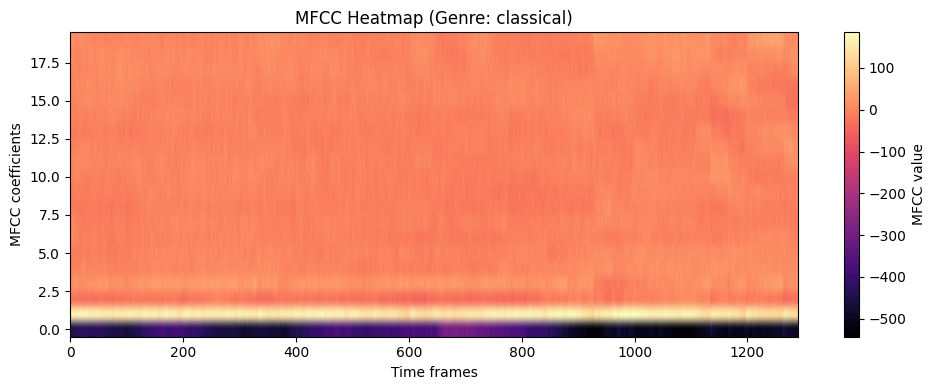

In [70]:
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_sample.T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label='MFCC value')
plt.xlabel("Time frames")
plt.ylabel("MFCC coefficients")
plt.title(f"MFCC Heatmap (Genre: {GENRES[y[sample_idx]]})")
plt.tight_layout()
plt.show()


# **Heatmap type 2: CNN feature-map heatmap (Conv layer activations)**

**Step 1: Build a model that outputs conv2**

In [71]:
from tensorflow.keras.models import Model

activation_model = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("conv2").output
)


**Step 2: Get activations for one sample**

In [72]:
sample_idx = 0
activation = activation_model.predict(X[sample_idx:sample_idx+1])

print(activation.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
(1, 33, 16)


In [73]:
activation = activation[0]  # shape: (T, C)

**Step 3: Plot CNN activation heatmap**

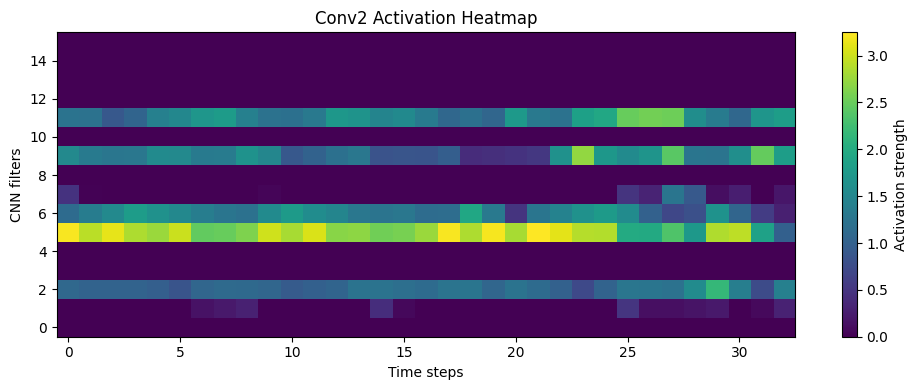

In [74]:
plt.figure(figsize=(10, 4))
plt.imshow(activation.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Activation strength')
plt.xlabel("Time steps")
plt.ylabel("CNN filters")
plt.title("Conv2 Activation Heatmap")
plt.tight_layout()
plt.show()

**Side-by-side genre comparison**

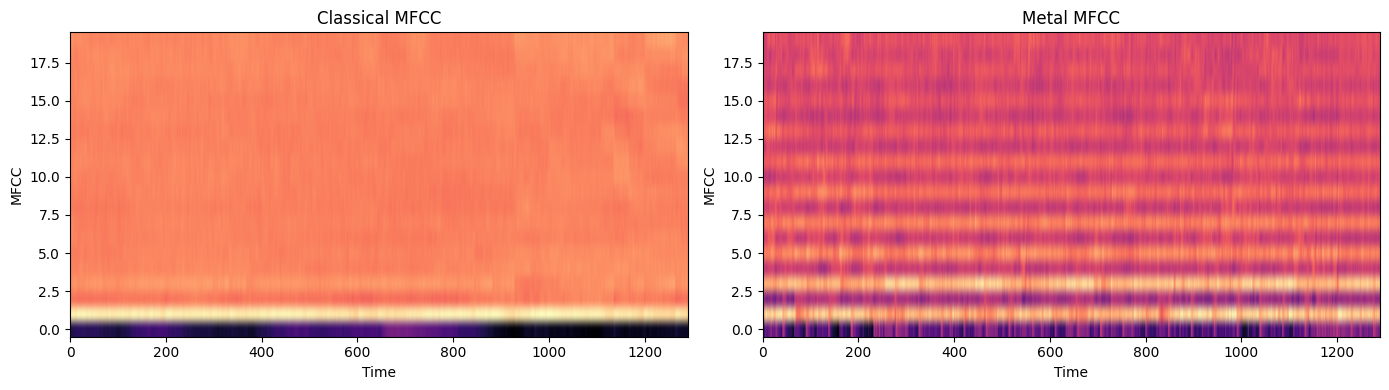

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Classical
idx_c = y.tolist().index(GENRES.index("classical"))
axes[0].imshow(X[idx_c].T, aspect='auto', origin='lower', cmap='magma')
axes[0].set_title("Classical MFCC")

# Metal
idx_m = y.tolist().index(GENRES.index("metal"))
axes[1].imshow(X[idx_m].T, aspect='auto', origin='lower', cmap='magma')
axes[1].set_title("Metal MFCC")

for ax in axes:
    ax.set_xlabel("Time")
    ax.set_ylabel("MFCC")

plt.tight_layout()
plt.show()


**PCA Visualization**

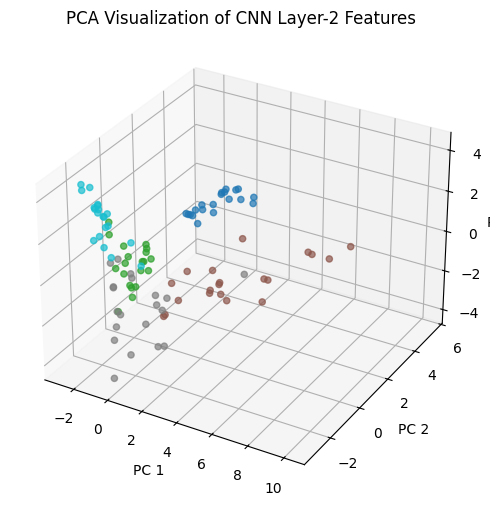

In [76]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_test_feat)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    c=y_test,
    cmap='tab10',
    alpha=0.7
)

ax.set_title("PCA Visualization of CNN Layer-2 Features")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

plt.show()
